In [91]:
# Gensim 
import gensim
import gensim.corpora as corpora

import datetime
import json
import numpy as np
import pandas as pd
import nltk
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim as gensimvis

from pprint import pprint
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


warnings.filterwarnings("ignore", category=DeprecationWarning)

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['font.size'] = 12

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Danila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Danila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pyLDAvis.__version__

'2.1.2'

## Определение вспомогательных функций 

In [3]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    
    return text

# Define functions for bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

## Получение данных



In [4]:
users_posts_part_1 = json.load(open('users_posts_part_1.json'))
users_posts_part_2 = json.load(open('users_posts_part_2.json'))

In [5]:
data = []
for user_id, items in users_posts_part_1.items():
    for item in items:
        data.append((user_id, item['date'], item['text']))

# for user_id, items in users_posts_part_2.items():
#     for item in items:
#         data.append((user_id, item['date'], item['text']))

In [6]:
df = pd.DataFrame(data, columns=['u_id', 'date', 'text'])

In [7]:
df

,u_id,date,text
0,1,1525805964,"Иногда говорят, что Telegram был заблокирован ..."
1,1,1525352753,"Михаил Светов, организатор прошедшего митинга ..."
2,1,1525187997,
3,1,1525168885,"Наблюдаю, как несмотря на проливной дождь, по ..."
4,1,1525107823,"Потрясающая акция в Москве. Более 12,000 челов..."
...,...,...,...
25397,566,1521891237,
25398,566,1521788147,С добрым утром 😊
25399,566,1521753210,
25400,566,1521526008,#утро


## Предварительная обработка текста и его токенизация

In [8]:
df['tokenized_text'] = df['text'].apply(preprocess) ## Предварительная обработка текста и его токенизация

df['clear_text'] = df['tokenized_text'].apply(lambda x: ' '.join(x))

In [9]:
df.head(5)

,u_id,date,text,tokenized_text,clear_text
0,1,1525805964,"Иногда говорят, что Telegram был заблокирован ...","[говорят, telegram, заблокирован, россии, зако...",говорят telegram заблокирован россии закон зак...
1,1,1525352753,"Михаил Светов, организатор прошедшего митинга ...","[михаил, светов, организатор, прошедшего, мити...",михаил светов организатор прошедшего митинга с...
2,1,1525187997,,[],
3,1,1525168885,"Наблюдаю, как несмотря на проливной дождь, по ...","[наблюдаю, несмотря, проливной, дождь, невском...",наблюдаю несмотря проливной дождь невскому про...
4,1,1525107823,"Потрясающая акция в Москве. Более 12,000 челов...","[потрясающая, акция, москве, человек, выступил...",потрясающая акция москве человек выступили сво...


In [10]:
data_words = df['tokenized_text'].tolist() # Convert to list

print(data_words[3])

['наблюдаю', 'несмотря', 'проливной', 'дождь', 'невскому', 'проспекту', 'данный', 'момент', 'движется', 'огромная', 'колонна', 'которая', 'скандирует', 'лозунги', 'защиту', 'свободного', 'интернета', 'подобное', 'сочетание', 'природных', 'условий', 'энергии', 'людей', 'возможно', 'петербурге', 'обновлено', 'спасибо', 'петербуржцам', 'стойкость', 'смелость', 'digitalresistance']


## Построение биграм

In [11]:
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [12]:
data_words_bigrams = make_bigrams(data_words)

## Подготовка параметров для LDA 

In [13]:
# Создание словаря
id2word = corpora.Dictionary(data_words_bigrams)

# Создание корпуса текста
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 2), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 4), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 4), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 2), (80, 1), (81, 1)]]


## Отбор подходящего количества топиков для алгоритма LDA

In [14]:
n_topics_list = list(range(5, 15))
coherence_ldas = []
log_perplexity = []

for i, n_topics in enumerate(n_topics_list):
    print(f'Текущая итерация: {i}')
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True) 

    coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus,  coherence='u_mass')
    coherence_ldas.append(coherence_model_lda.get_coherence())
    log_perplexity.append(lda_model.log_perplexity(corpus))

Текущая итерация: 0
Текущая итерация: 1
Текущая итерация: 2
Текущая итерация: 3
Текущая итерация: 4
Текущая итерация: 5
Текущая итерация: 6
Текущая итерация: 7
Текущая итерация: 8
Текущая итерация: 9


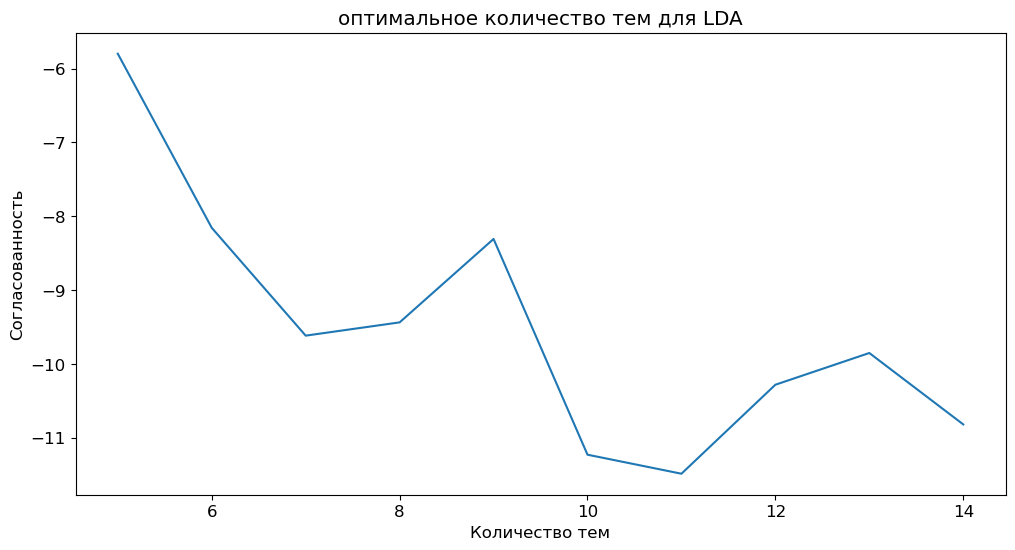

In [15]:
plt.plot(n_topics_list, coherence_ldas)
plt.title("оптимальное количество тем для LDA")
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.show()

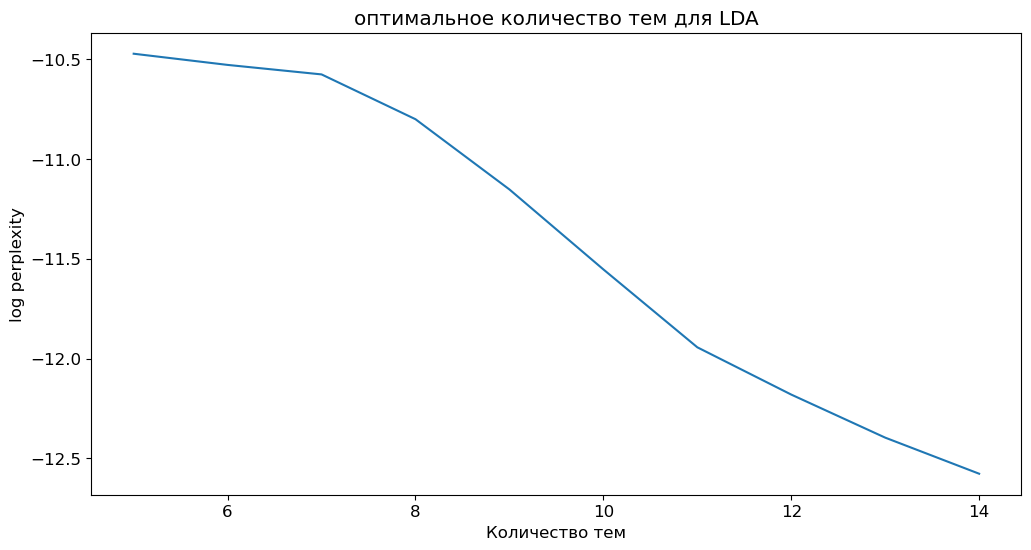

In [16]:
plt.plot(n_topics_list, log_perplexity)
plt.title("оптимальное количество тем для LDA")
plt.xlabel("Количество тем")
plt.ylabel("log perplexity")
plt.show()

In [17]:
m_lp_c = []
for lp, c in zip(log_perplexity, coherence_ldas):
    m_lp_c.append(2*lp*c/(lp+c))

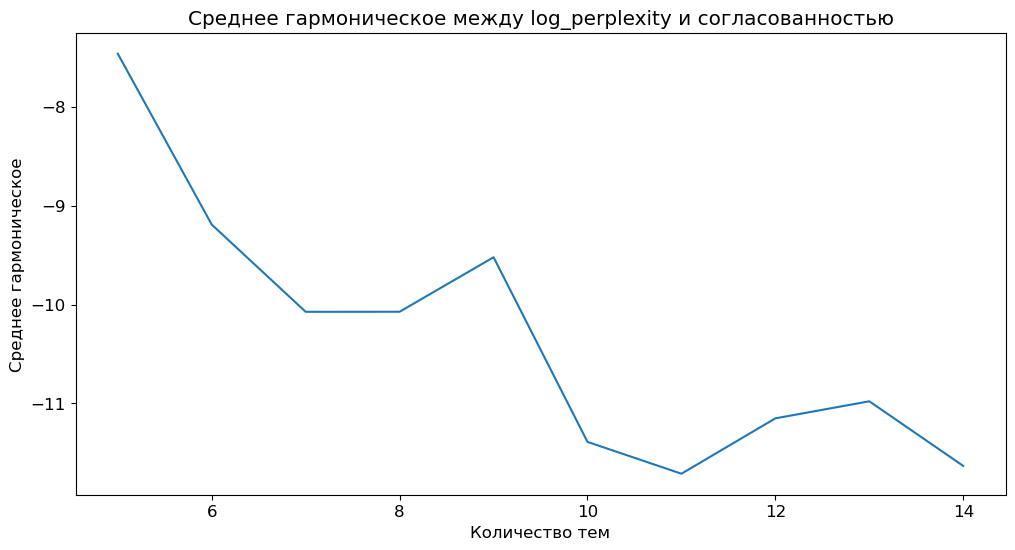

In [18]:
plt.plot(n_topics_list, m_lp_c)
plt.title("Среднее гармоническое между log_perplexity и согласованностью")
plt.xlabel("Количество тем")
plt.ylabel("Среднее гармоническое")
plt.show()

## Исходя из графиков выше было решено выбрать 9 тем. Так как на графике среднего гармонического относительной серединой является именно эта точка

In [19]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.002*"дома" + 0.002*"сегодня" + 0.001*"доброе_утро" + 0.001*"вечер" + 0.001*"утро" + 0.001*"друзья" + 0.001*"c" + 0.001*"дом" + 0.001*"году" + 0.001*"машину"'), (1, '0.015*"the" + 0.010*"днём_рождения" + 0.010*"a" + 0.009*"and" + 0.008*"of" + 0.008*"to" + 0.007*"i" + 0.006*"in" + 0.005*"it" + 0.005*"you"'), (2, '0.018*"это" + 0.005*"очень" + 0.004*"которые" + 0.004*"время" + 0.003*"ещё" + 0.003*"сегодня" + 0.003*"просто" + 0.003*"лет" + 0.003*"который" + 0.002*"вообще"'), (3, '0.020*"это" + 0.014*"http" + 0.006*"очень" + 0.005*"всё" + 0.005*"просто" + 0.005*"ещё" + 0.003*"день" + 0.003*"жизни" + 0.003*"хочу" + 0.003*"пока"'), (4, '0.006*"всем" + 0.006*"спасибо" + 0.005*"это" + 0.004*"очень" + 0.002*"мои" + 0.002*"рождения" + 0.002*"сегодня" + 0.002*"поздравления" + 0.002*"друзья" + 0.002*"поздравляю_днем"'), (5, '0.003*"зенит_зенит" + 0.003*"немного" + 0.002*"очень" + 0.001*"наш" + 0.001*"настроение" + 0.001*"привет" + 0.001*"we" + 0.001*"go" + 0.001*"господь" + 0.001*"зенит"'),

## Валидация итоговой модели

In [21]:
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
cm = CoherenceModel(model=lda_model, corpus=corpus,  coherence='u_mass')
print(cm.get_coherence())  # get coherence value


Perplexity:  -11.152326953771228
-8.306504807148535


## pyLDAvis - LDA визуализация

In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)


C:\Users\Danila\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


In [32]:
pyLDAvis.show(vis)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [18/Oct/2022 18:39:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2022 18:39:49] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2022 18:39:49] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2022 18:39:49] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2022 18:39:49] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2022 18:39:55] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2022 18:39:55] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2022 18:39:55] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2022 18:39:55] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2022 18:39:55] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...


## Составление профиля интересов пользователей
### Построение среднего вектора тем для каждого из пользователей

In [33]:
def generate_topic_vectors_for_texts(lda_model, corpus, n_topics, event_ids):
    topic_vectors = {}
    
    for row, event_id in zip(lda_model[corpus], event_ids):
        dict_row = {k: v for k, v in row[0]}
        topic_vector = []
        for i in range(n_topics):
            if i in dict_row:
                topic_vector.append(round(dict_row[i], 4))
            else:
                topic_vector.append(0)
                
        topic_vectors[event_id] = topic_vector
        
    return topic_vectors

In [34]:
event_topic_modeling_features_dict = generate_topic_vectors_for_texts(lda_model, corpus, 9, list(df.index.values))

In [42]:
users_comment_indexes = defaultdict(list)
for i, user_id in enumerate(df['u_id']):
    users_comment_indexes[user_id].append(i)

## В статика: по всем постам

In [52]:
mean_topics_by_user = defaultdict(list)
for user_id, indexes in users_comment_indexes.items():
    for index in indexes:
        mean_topics_by_user[user_id].append(np.array(event_topic_modeling_features_dict[index]))
        
mean_topics_by_user = {u: np.mean(v, axis=0) for u, v in mean_topics_by_user.items()}

In [72]:
kmeans = KMeans(n_clusters=3).fit(list(mean_topics_by_user.values()))
pedicted_clusters =  kmeans.predict(list(mean_topics_by_user.values()))

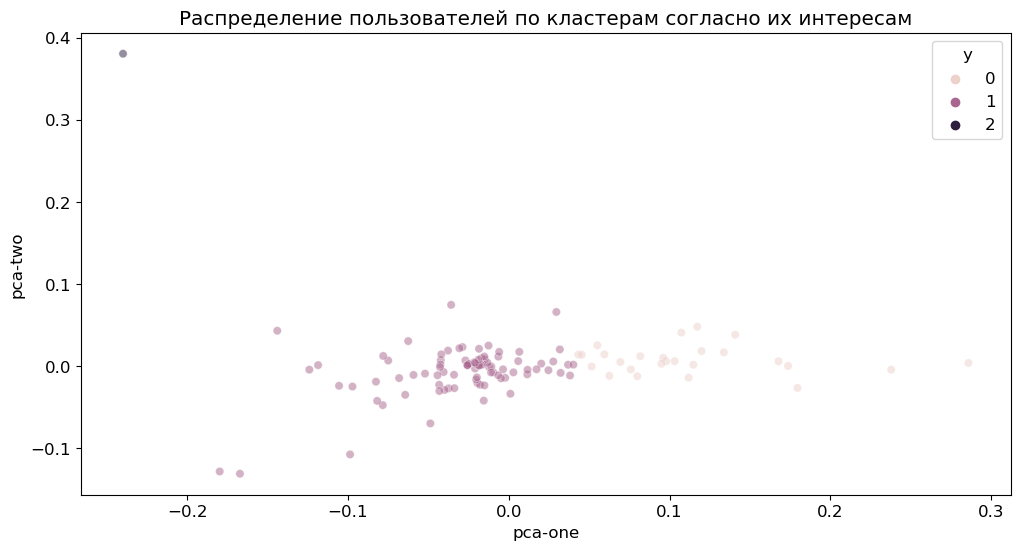

In [75]:
## Снижение размерности
pca = PCA(n_components=2)
pca_result = pca.fit_transform(list(mean_topics_by_user.values()))

test_df = pd.DataFrame()
test_df['pca-one'] = pca_result[:,0]
test_df['pca-two'] = pca_result[:,1] 
test_df['y'] = pedicted_clusters

## Отрисовка графиков
fig, ax1 = plt.subplots(1)

ax1.set_title('Распределение пользователей по кластерам согласно их интересам')
ax1 = sns.scatterplot(
    ax=ax1,
    x="pca-one", y="pca-two",
    hue="y",
    data=test_df,
    legend="full",
    alpha=0.5
)


## Распределение топиков для каждого из профилей

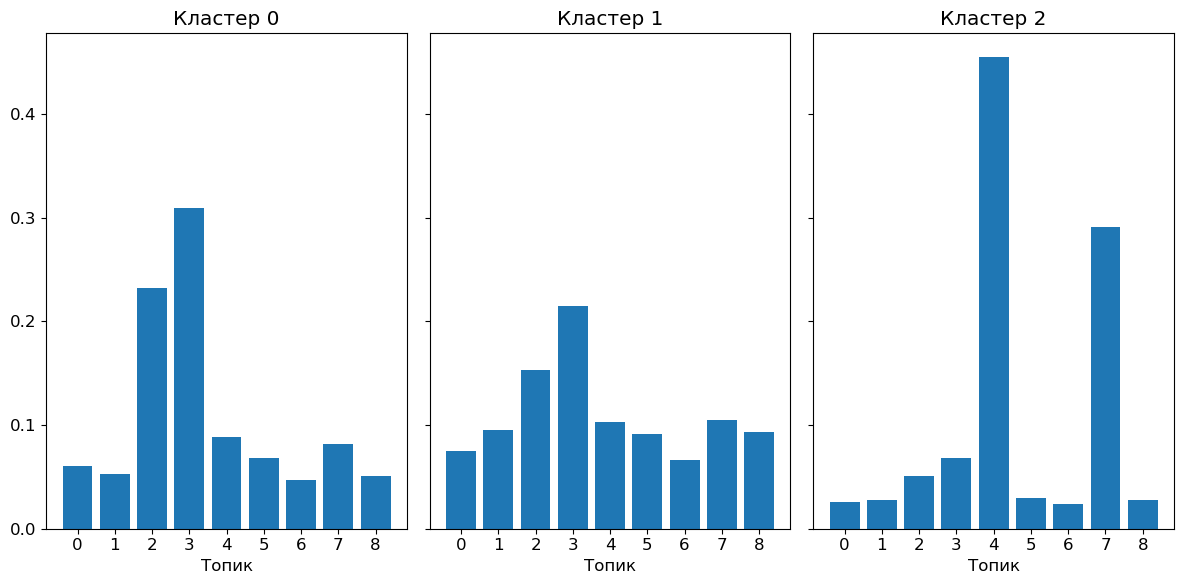

In [85]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
topics = list(range(0, 9))

axs[0].bar([str(f) for f in topics], kmeans.cluster_centers_[0])
axs[0].set_title('Кластер 0')
axs[0].set_xlabel('Топик')

axs[1].bar([str(f) for f in topics], kmeans.cluster_centers_[1])
axs[1].set_title('Кластер 1')
axs[1].set_xlabel('Топик')

axs[2].bar([str(f) for f in topics], kmeans.cluster_centers_[2])
axs[2].set_title('Кластер 2')
axs[2].set_xlabel('Топик');

## В статика: по годовым интервалам

In [103]:
df['quarter'] = df['date'].apply(lambda x: int(datetime.date.fromtimestamp(x).month / 4) + 1)

In [126]:
dataset_1 = defaultdict(list)
df_1 = df[df['quarter'] == 1]
for i, u_id in zip(list(df_1.index), df_1['u_id']):
    dataset_1[u_id].append(np.array(event_topic_modeling_features_dict[i]))
    
dataset_1 = {u: np.mean(v, axis=0) for u, v in dataset_1.items()}

kmeans_1 = KMeans(n_clusters=3).fit(list(dataset_1.values()))
pedicted_clusters_1 =  kmeans_1.predict(list(dataset_1.values()))

In [127]:
dataset_2 = defaultdict(list)
df_2 = df[df['quarter'] == 2]
for i, u_id in zip(list(df_2.index), df_2['u_id']):
    dataset_2[u_id].append(np.array(event_topic_modeling_features_dict[i]))
    
dataset_2 = {u: np.mean(v, axis=0) for u, v in dataset_2.items()}

kmeans_2 = KMeans(n_clusters=3).fit(list(dataset_2.values()))
pedicted_clusters_2 =  kmeans_2.predict(list(dataset_2.values()))

In [128]:
dataset_3 = defaultdict(list)
df_3 = df[df['quarter'] == 3]
for i, u_id in zip(list(df_3.index), df_3['u_id']):
    dataset_3[u_id].append(np.array(event_topic_modeling_features_dict[i]))
    
dataset_3 = {u: np.mean(v, axis=0) for u, v in dataset_3.items()}

kmeans_3 = KMeans(n_clusters=3).fit(list(dataset_3.values()))
pedicted_clusters_3 =  kmeans_3.predict(list(dataset_3.values()))

In [129]:
dataset_4 = defaultdict(list)
df_4 = df[df['quarter'] == 3]
for i, u_id in zip(list(df_4.index), df_4['u_id']):
    dataset_4[u_id].append(np.array(event_topic_modeling_features_dict[i]))
    
dataset_4 = {u: np.mean(v, axis=0) for u, v in dataset_4.items()}

kmeans_4 = KMeans(n_clusters=3).fit(list(dataset_4.values()))
pedicted_clusters_4 =  kmeans_4.predict(list(dataset_4.values()))

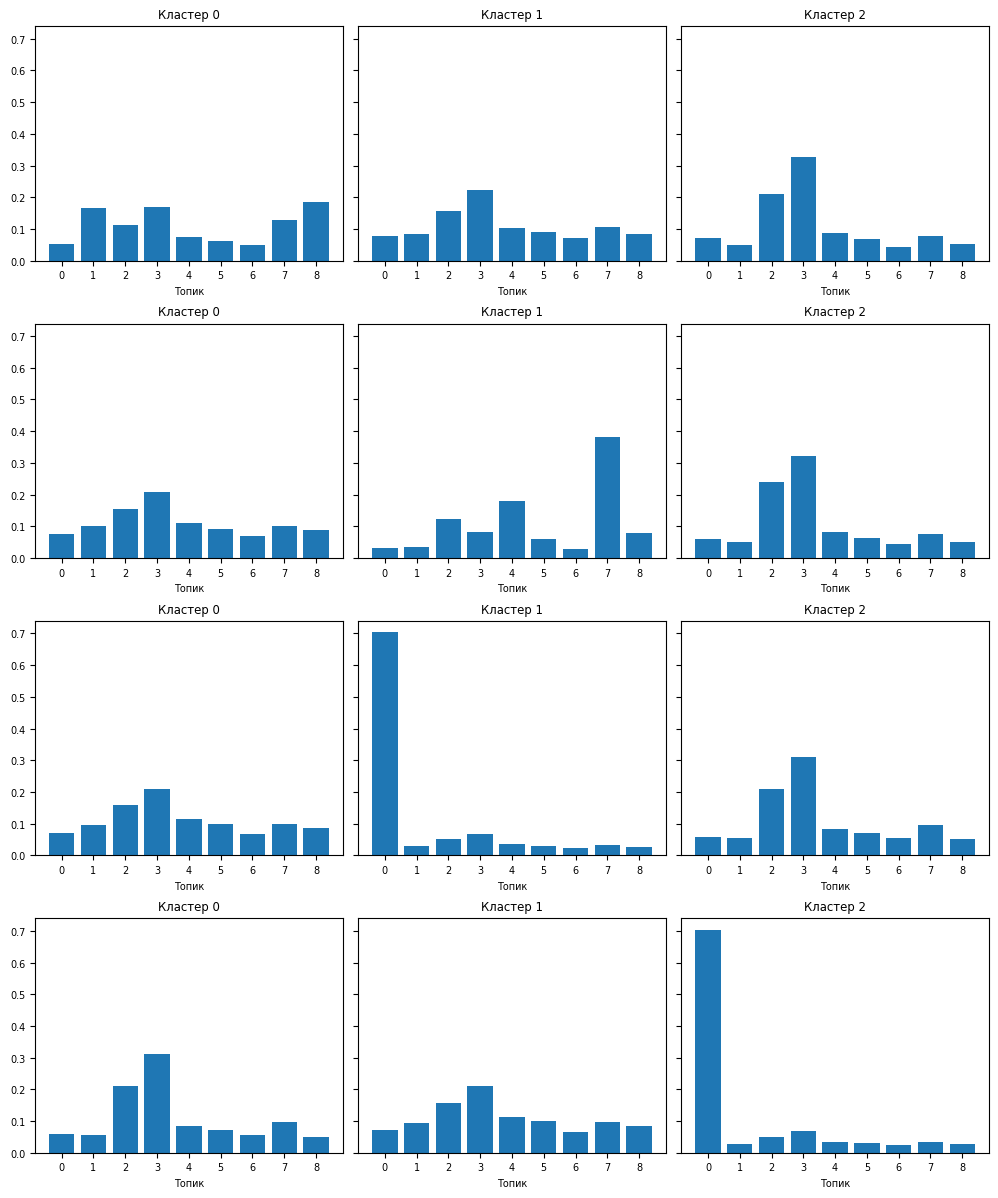

In [167]:
plt.rcParams["figure.figsize"] = (10, 12)
fig, axs = plt.subplots(4, 3, sharey=True, tight_layout=True)

topics = list(range(0, 9))

## Квартал 1
axs[0][0].bar([str(f) for f in topics], kmeans_1.cluster_centers_[0])
axs[0][0].set_title('Кластер 0')
axs[0][0].set_xlabel('Топик')

axs[0][1].bar([str(f) for f in topics], kmeans_1.cluster_centers_[1])
axs[0][1].set_title('Кластер 1')
axs[0][1].set_xlabel('Топик')

axs[0][2].bar([str(f) for f in topics], kmeans_1.cluster_centers_[2])
axs[0][2].set_title('Кластер 2')
axs[0][2].set_xlabel('Топик');

## Квартал 2
axs[1][0].bar([str(f) for f in topics], kmeans_2.cluster_centers_[0])
axs[1][0].set_title('Кластер 0')
axs[1][0].set_xlabel('Топик')

axs[1][1].bar([str(f) for f in topics], kmeans_2.cluster_centers_[1])
axs[1][1].set_title('Кластер 1')
axs[1][1].set_xlabel('Топик')

axs[1][2].bar([str(f) for f in topics], kmeans_2.cluster_centers_[2])
axs[1][2].set_title('Кластер 2')
axs[1][2].set_xlabel('Топик');

## Квартал 3
axs[2][0].bar([str(f) for f in topics], kmeans_3.cluster_centers_[0])
axs[2][0].set_title('Кластер 0')
axs[2][0].set_xlabel('Топик')

axs[2][1].bar([str(f) for f in topics], kmeans_3.cluster_centers_[1])
axs[2][1].set_title('Кластер 1')
axs[2][1].set_xlabel('Топик')

axs[2][2].bar([str(f) for f in topics], kmeans_3.cluster_centers_[2])
axs[2][2].set_title('Кластер 2')
axs[2][2].set_xlabel('Топик');


## Квартал 4
axs[3][0].bar([str(f) for f in topics], kmeans_4.cluster_centers_[0])
axs[3][0].set_title('Кластер 0')
axs[3][0].set_xlabel('Топик')

axs[3][1].bar([str(f) for f in topics], kmeans_4.cluster_centers_[1])
axs[3][1].set_title('Кластер 1')
axs[3][1].set_xlabel('Топик')

axs[3][2].bar([str(f) for f in topics], kmeans_4.cluster_centers_[2])
axs[3][2].set_title('Кластер 2')
axs[3][2].set_xlabel('Топик');

In [168]:
user_dataset = defaultdict(list)

mapping = dict(zip(dataset_1.keys(), pedicted_clusters_1))

for u_id in df['u_id'].unique():
    user_dataset[u_id].append(mapping.get(u_id, -1))

mapping = dict(zip(dataset_2.keys(), pedicted_clusters_2))
for u_id in df['u_id'].unique():
    user_dataset[u_id].append(mapping.get(u_id, -1))
    
mapping = dict(zip(dataset_3.keys(), pedicted_clusters_3))
for u_id in df['u_id'].unique():
    user_dataset[u_id].append(mapping.get(u_id, -1))
    
mapping = dict(zip(dataset_4.keys(), pedicted_clusters_4))
for u_id in df['u_id'].unique():
    user_dataset[u_id].append(mapping.get(u_id, -1))

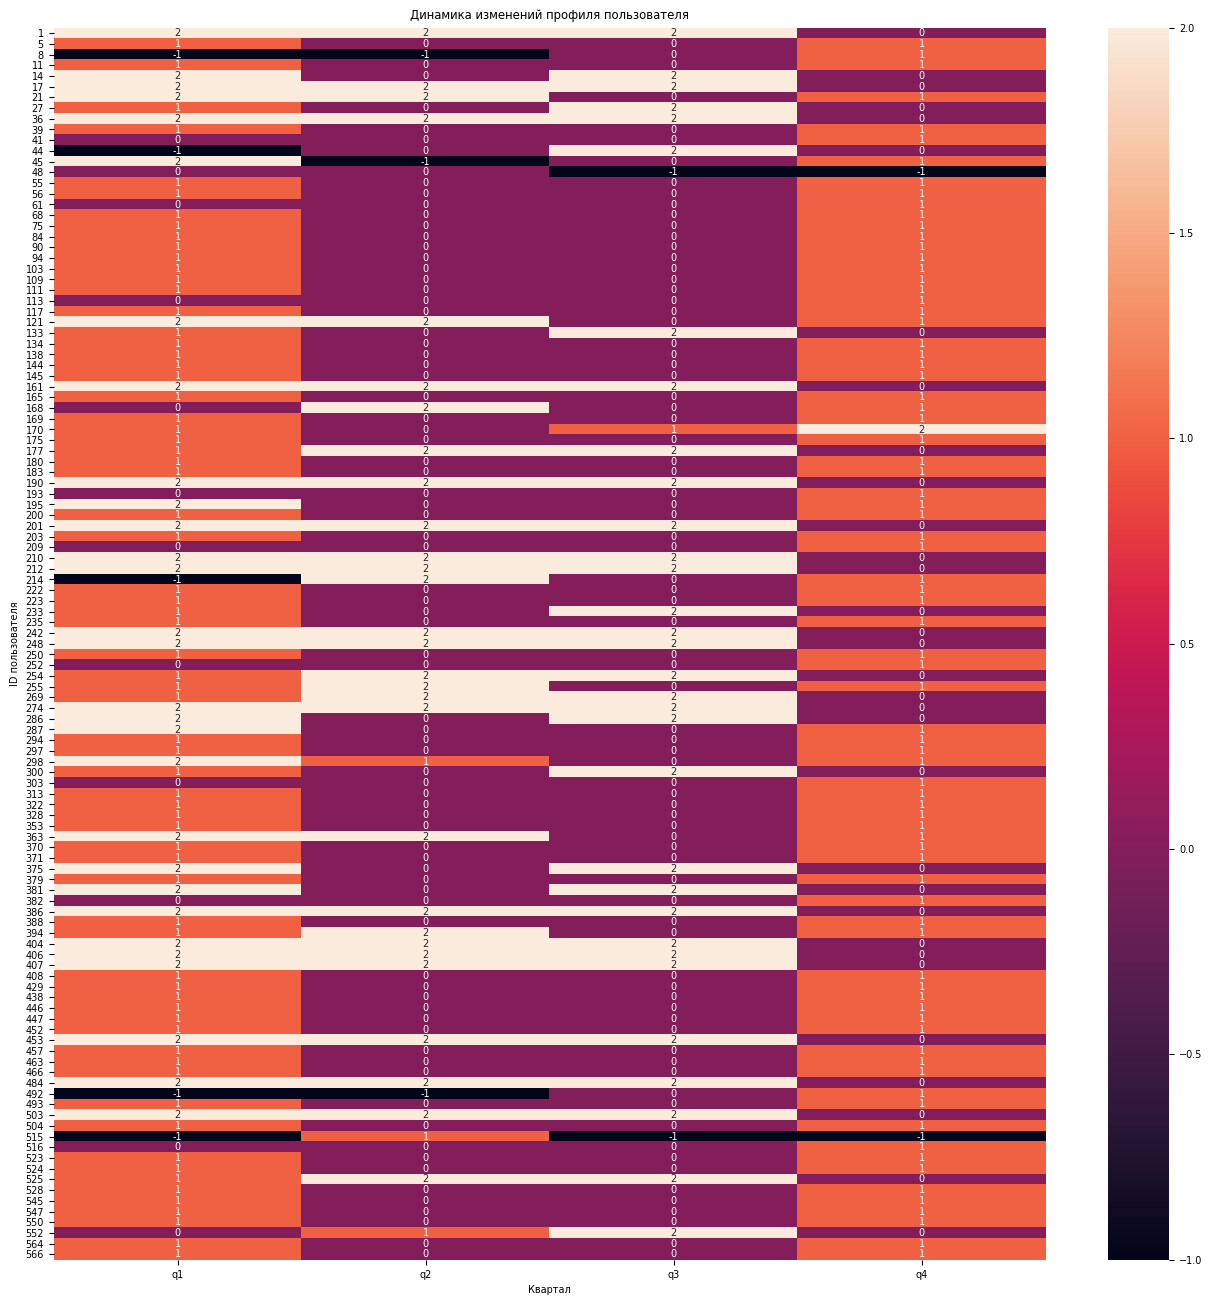

In [169]:
plt.rcParams["figure.figsize"] = (16, 16)
plt.rcParams['font.size'] = 7
ax = sns.heatmap(pd.DataFrame(user_dataset.values(), columns=['q1', 'q2', 'q3', 'q4'], index=user_dataset.keys()), annot=True)

ax.set(xlabel="Квартал", ylabel="ID пользователя", title="Динамика изменений профиля пользователя");